# Solution

This notebook is the solution of Problem 3 of the `IV Workshop de Computação Quântica`, for the team `QGSS20 Team`.

# Imports

In [1]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
from qctrl import Qctrl

# Apply Q-CTRL style to plots created in pyplot.
plt.style.use(qctrlvisualizer.get_qctrl_style())

# Start a Boulder Opal session.
qctrl = Qctrl()

Q-CTRL package upgrade available. Your version is 14.2.1. New Version is 14.3.0.


# Creating Helper functions

In [6]:
from typing import List

control_count = 100
segment_count = 10
duration = 50.0
shot_count = 1000

def initialize_parameters() -> np.ndarray:
    """Initializes the parameters needed for the optimization.

    Returns:
        np.ndarray: Initialization of random parameters.
    """
    return np.random.random(size=[control_count, 2 * segment_count])

def calculate_values(parameters: np.ndarray) -> np.ndarray:
    """Calculate the values needed for the pulse.

    Args:
        parameters (np.ndarray): np.array of parameters of shape
        (2 * segment_count)

    Returns:
        np.ndarray: Normalized value of the pulse.
    """
    parameters = parameters.reshape(2, segment_count)
    values = (parameters[0] + 1j * parameters[1])
    return values / np.linalg.norm(values)

def calculate_values_hadamard(parameters: np.ndarray) -> np.ndarray:
    """Calculate the values needed for the pulse.

    Args:
        parameters (np.ndarray): np.array of parameters of shape
        (2 * segment_count)

    Returns:
        np.ndarray: Normalized value of the pulse.
    """
    parameters = parameters.reshape(2, segment_count)
    values = (parameters[0] + 1j * parameters[1])
    return values / 2 / np.linalg.norm(values)

def create_controls(parameters: np.ndarray) -> List[dict]:
    """ Create controls for `control_count` number of
    pulses, given `parameters`.

    Args:
        parameters (np.ndarray): np.array of parameters of 
        shape (control_count, 2 * segment_count)

    Returns:
        List[dict]: List of pulse schedules.
    """
    controls = []
    for k in range(control_count):
        values = calculate_values(parameters[k])
        controls.append({"duration": duration, "values": values})
    
    return controls

def run_experiments(parameters: np.array) -> List[float]:
    """Run experiments for a given set of parameters.

    Args:
        parameters (np.array): np.array of parameters of 
        shape (control_count, 2 * segment_count)

    Returns:
        List[float]: Results of the experiment
    """
    # Create control parameters for the experiment
    controls = create_controls(parameters)
    
    # Run the experiment on the cloud
    experiment_results = qctrl.functions.calculate_hackathon_measurements(
        controls=controls, shot_count=shot_count
    )
    
    measurements = experiment_results.measurements

    p0 = []
    p1 = []
    
    for _, measurement_counts in enumerate(measurements):
        p0.append((0.5 - (measurement_counts.count(0) / shot_count))**2)
        p1.append((0.5 - (measurement_counts.count(1) / shot_count))**2)
    
    return list(np.array(p1) + np.array(p0))

In [7]:
def organize_results(parameters, infidelities):
    """
    This function accepts a list of parameters and a list of costs, and
    orgnizes them in a format that is accepted by the closed-loop optimizer.
    """
    return [
        qctrl.types.closed_loop_optimization_step.CostFunctionResult(
            parameters=list(parameters), cost=cost
        )
        for parameters, cost in zip(parameters, infidelities)
    ]

# Defining the optimizers

In [8]:
type_of_optimization = "gaussian process"

bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=-5 * np.pi / duration, upper_bound=5 * np.pi / duration
)

if type_of_optimization == "gaussian process":
    length_scale_bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
        lower_bound=1e-10, upper_bound=1e5
    )

    initializer = qctrl.types.closed_loop_optimization_step.GaussianProcessInitializer(
        length_scale_bounds=[length_scale_bound] * 2 *segment_count,
        bounds=[bound] * 2 * segment_count,
        rng_seed=0,
    )

    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        gaussian_process_initializer=initializer,
    )

elif type_of_optimization == "simulated annealing":
    initializer = qctrl.types.closed_loop_optimization_step.SimulatedAnnealingInitializer(
        bounds=[bound] * 2 * segment_count,
        temperatures=[400000] * 2 * segment_count,
        temperature_cost=0.1,
        rng_seed=0,
    )

    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        simulated_annealing_initializer=initializer
    )

else:
    raise NotImplementedError("type_of_optimization not implemented")

# Optimization Procedure

In [9]:
from IPython.display import clear_output

test_point_count = control_count

parameter_set = initialize_parameters()
experiment_results = run_experiments(parameter_set)
controls = create_controls(parameter_set)

best_cost, best_controls = min(
    zip(experiment_results, parameter_set), key=lambda params: params[0]
)
optimization_count = 0



# Set the target infidelity for the H gate
target_infidelity = 0.1

while best_cost > target_infidelity:
    
    # Print the current best cost.
    optimization_steps = (
        "optimization step" if optimization_count == 1 else "optimization steps"
    )
    
    print(
        f"Best infidelity after {optimization_count} Boulder Opal {optimization_steps}: {best_cost}"
    )
    
    
    # Organize the experiment results into the proper input format.
    results = organize_results(parameter_set, experiment_results)

    # Call the automated closed-loop optimizer and obtain the next set of test points.
    optimization_result = qctrl.functions.calculate_closed_loop_optimization_step(
        optimizer=optimizer, results=results , test_point_count=test_point_count
    )
    
    optimization_count += 1

    # Organize the data returned by the automated closed-loop optimizer.
    parameter_set = np.array(
        [test_point.parameters for test_point in optimization_result.test_points]
    )
    
    # Run the optimizer
    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        state=optimization_result.state
    )
    
    
    
    # Obtain experiment results that the automated closed-loop optimizer requested.
    experiment_results = run_experiments(parameter_set)
    
    
    # Record the best results after this round of experiments.
    cost, controls = min(
        zip(experiment_results, parameter_set), key=lambda params: params[0]
    )
    
    
    if cost < best_cost:
        best_cost = cost
        best_controls = controls

    clear_output()

Your task calculate_hackathon_measurements (action_id="708296") has completed.


Infidelity: 1.800000000000003e-05


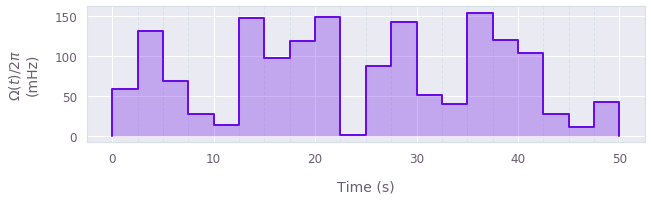

In [24]:
from qctrlvisualizer import get_qctrl_style, plot_controls

# Print final best cost.
print(f"Infidelity: {best_cost}")

# Plot controls that correspond to the best cost.
plot_controls(
    figure=plt.figure(),
    controls={
        r"$\Omega(t)$": [
            {"duration": duration  / len(best_controls), "value": value}
            for value in best_controls
        ]
    },
)

In [11]:
def create_optimal_controls(parameters: np.ndarray, repetitions: int=1) -> List[dict]:
    """Create a list of dictionary with the optimal controls for the NOT gate.

    Args:
        parameters (np.ndarray): np.array of parameters of shape
        (2 * segment_count)
        
        repetitions (int, optional): Number of repetition. Defaults to 1.

    Returns:
        List[dict] : List of optimal pulse schedules.
    """
    controls = []
    values = calculate_values(parameters)
    
    if repetitions != 1:
        controls.append({"duration": duration,
                         "values": values,
                         "repetition_count": repetitions})
    
    else:
        controls.append({"duration": duration,
                         "values": values,
                         })
    
    return controls

# Repetition Plots

## Hadamard Gate

In [21]:
import seaborn as sns
sns.set()

repetitions = np.arange(1, 20)
p0, p1, p2 = [], [], []
for rep in repetitions:
    controls_hadamard = create_optimal_controls(best_controls, repetitions=int(rep))

    measurements = qctrl.functions.calculate_hackathon_measurements(
            controls=controls_hadamard, shot_count=shot_count
            ).measurements
    
    for k, measurement_counts in enumerate(measurements):
        p0.append(measurement_counts.count(0) / shot_count)
        p1.append(measurement_counts.count(1) / shot_count)
        p2.append(measurement_counts.count(2) / shot_count)
    
    clear_output()

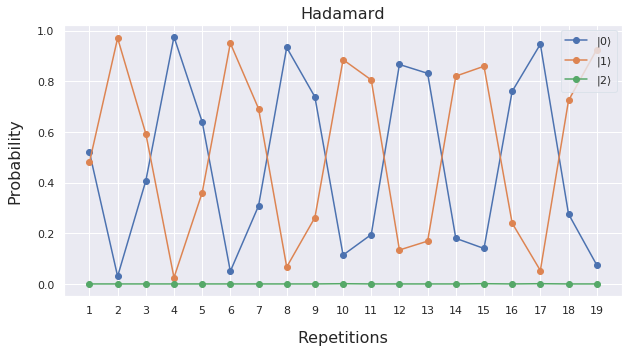

In [22]:
plt.plot(repetitions, p0, '-o', label=r"$| 0 \rangle$")
plt.plot(repetitions, p1, '-o', label=r"$| 1 \rangle$")
plt.plot(repetitions, p2, '-o', label=r"$| 2 \rangle$")
plt.title("Hadamard", size=16)
plt.xlabel("Repetitions", size=16)
plt.ylabel("Probability", size=16)
plt.xticks([i for i in repetitions])
plt.legend()
plt.show()

# Testing the output of the gate

In [19]:
controls = create_optimal_controls(best_controls, repetitions=1)

measurements = qctrl.functions.calculate_hackathon_measurements(
        controls=controls, shot_count=shot_count
    ).measurements


for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

Your task calculate_hackathon_measurements (action_id="708358") has completed.
control #0: P(|0>) = 0.58, P(|1>) = 0.42, P(|2>) = 0.00


# Create Submission

In [18]:
import jsonpickle.ext.numpy as jsonpickle_numpy
import jsonpickle

jsonpickle_numpy.register_handlers()

hadamard_control = controls[0]
json_hadamard_control = jsonpickle.encode(hadamard_control)
with open("hadamard_control.json", "w") as file:
    file.write(json_hadamard_control)